In [1]:
from __future__ import annotations

import torch
import torch_geometric.data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]

print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Finding cliques

1. Load the data in our own representation and get all 3-cliques from the graph

In [14]:
from graph import Graph, Node

graph = Graph(data.edge_index, data.x)
cliques = graph.get_all_3cliques()

2. Sort the cliques by given criteria. Currently it is sum of distances between all pairs of feature vectors: $\left| f_a - f_b \right| + \left| f_a - f_c \right| + \left| f_b - f_c \right|$ where $f_v$ is a feature vector of node $v$.

In [15]:
from numpy.linalg import norm
from typing import Tuple


def get_nodes_distance(a: Node, b: Node, c: Node) -> float:
    """Returns sum of pairwise distances of given nodes' feature vectors"""
    a_class, b_class, c_class = None, None, None
    if data.train_mask[a.name]:
        a_class = data.y[a.name]
    if data.train_mask[b.name]:
        b_class = data.y[b.name]
    if data.train_mask[c.name]:
        c_class = data.y[c.name]

    ab_same_class = int(a_class == b_class)
    ac_same_class = int(a_class == c_class)
    bc_same_class = int(b_class == c_class)

    ab_len = norm(a.features - b.features)
    ac_len = norm(a.features - c.features)
    bc_len = norm(b.features - c.features)

    return ab_len + ac_len + bc_len - (ab_same_class + ac_same_class + bc_same_class)


def node_cmp(tup: Tuple[Node, Node, Node]) -> float:
    """Just a comparator with """
    return get_nodes_distance(*tup)


cliques.sort(key=node_cmp)

3. When the cliques are sorted, we want to do exactly one round of 3-clique-folding:
    - Take the clique with the smallest distance
    - Take average ($\frac{1}{3} * \Sigma_{i = 0}^2\ f_i$) of their feature vector, call it "common features"
    - Take all edges coming to all of the nodes from clique: $E\prime = \left\{ (v_k, v_j) | v_k \in (v_a, v_b, v_c),\ \neg j \in (a, b, c) \right\}$
    - Delete nodes $v_a$, $v_b$, $v_c$ and all of their edges from the graph
    - Create a new node with common features and all of the edges $E\prime$

In [16]:
while len(cliques):
    top = cliques.pop(0)
    graph.replace_3clique_with_node(top)
    # delete all cliques containing any vertices from `top`
    cliques = list(filter(
        lambda cl: all([v not in cl for v in top]),
        cliques,
    ))

In [17]:
processed_data = graph.get_graph_data(data)
processed_data

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0476, 0.0000])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0385,  ..., 0.0000, 0.0000, 0.0000])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([0., 0., 

TypeError: new() received an invalid combination of arguments - got (list, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [28]:
a = ...
from torch import Tensor
Tensor([bool(node.in_train_mask) for node in graph.nodes], dtype=torch.BoolTensor)

TypeError: new() received an invalid combination of arguments - got (list, dtype=torch.tensortype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


Now let us create 2 models: first one with default dataset, and the second one with preprocessed data where 3-cliques were merged in one node

In [68]:
default = GCNConv(in_channels=1433, out_channels=7)
cliques_merged = GCNConv(in_channels=1433, out_channels=7)

In [69]:
def train_and_test(model: GCNConv, data: torch_geometric.data.Data):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
        model.train()
        optimizer.zero_grad()  # Clear gradients.
        out = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask],
                         data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        return loss

    def test():
        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        return test_acc

    losses = []
    for epoch in range(1, 101):
        loss = train()
        losses.append(loss)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
    return losses

In [70]:
default_losses = train_and_test(default)

Epoch: 001, Loss: 1.9459
Epoch: 002, Loss: 1.9373
Epoch: 003, Loss: 1.9287
Epoch: 004, Loss: 1.9204
Epoch: 005, Loss: 1.9123
Epoch: 006, Loss: 1.9043
Epoch: 007, Loss: 1.8966
Epoch: 008, Loss: 1.8890
Epoch: 009, Loss: 1.8816
Epoch: 010, Loss: 1.8745
Epoch: 011, Loss: 1.8675
Epoch: 012, Loss: 1.8607
Epoch: 013, Loss: 1.8541
Epoch: 014, Loss: 1.8477
Epoch: 015, Loss: 1.8415
Epoch: 016, Loss: 1.8354
Epoch: 017, Loss: 1.8295
Epoch: 018, Loss: 1.8238
Epoch: 019, Loss: 1.8182
Epoch: 020, Loss: 1.8128
Epoch: 021, Loss: 1.8075
Epoch: 022, Loss: 1.8024
Epoch: 023, Loss: 1.7975
Epoch: 024, Loss: 1.7927
Epoch: 025, Loss: 1.7880
Epoch: 026, Loss: 1.7834
Epoch: 027, Loss: 1.7790
Epoch: 028, Loss: 1.7747
Epoch: 029, Loss: 1.7705
Epoch: 030, Loss: 1.7664
Epoch: 031, Loss: 1.7624
Epoch: 032, Loss: 1.7585
Epoch: 033, Loss: 1.7548
Epoch: 034, Loss: 1.7511
Epoch: 035, Loss: 1.7474
Epoch: 036, Loss: 1.7439
Epoch: 037, Loss: 1.7405
Epoch: 038, Loss: 1.7371
Epoch: 039, Loss: 1.7338
Epoch: 040, Loss: 1.7306


In [58]:
cliques_merged_losses = train_and_test(cliques_merged)

Model: Cliques merged model, Epoch: 001, Loss: 1.6129
Model: Cliques merged model, Epoch: 002, Loss: 1.6119
Model: Cliques merged model, Epoch: 003, Loss: 1.6094
Model: Cliques merged model, Epoch: 004, Loss: 1.6066
Model: Cliques merged model, Epoch: 005, Loss: 1.6041
Model: Cliques merged model, Epoch: 006, Loss: 1.6019
Model: Cliques merged model, Epoch: 007, Loss: 1.6000
Model: Cliques merged model, Epoch: 008, Loss: 1.5982
Model: Cliques merged model, Epoch: 009, Loss: 1.5965
Model: Cliques merged model, Epoch: 010, Loss: 1.5947
Model: Cliques merged model, Epoch: 011, Loss: 1.5929
Model: Cliques merged model, Epoch: 012, Loss: 1.5912
Model: Cliques merged model, Epoch: 013, Loss: 1.5894
Model: Cliques merged model, Epoch: 014, Loss: 1.5878
Model: Cliques merged model, Epoch: 015, Loss: 1.5862
Model: Cliques merged model, Epoch: 016, Loss: 1.5848
Model: Cliques merged model, Epoch: 017, Loss: 1.5834
Model: Cliques merged model, Epoch: 018, Loss: 1.5821
Model: Cliques merged model,

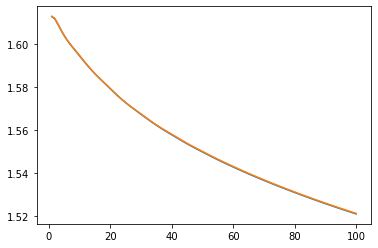

In [67]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 101)
plt.plot(x, np.array([loss.detach().numpy() for loss in default_losses]))
plt.plot(x, np.array([loss.detach().numpy() for loss in cliques_merged_losses]))
plt.show()

In [3]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [4]:
type(data)

torch_geometric.data.data.Data

In [6]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [7]:
data.train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [8]:
data.test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [13]:
data.val_mask

tensor([False, False, False,  ..., False, False, False])